In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline

# Create a Spark session
spark = SparkSession.builder.appName("Penguins Species Cluster Analysis").getOrCreate()

df = spark.read.csv("data/penguins_size.csv", header=True, inferSchema=True)
print(f'Initial DataFrame size: {df.count()} rows')

# Drop rows with NA strings and cast safely
df_clean = df.filter((col("culmen_length_mm").isNotNull()) & 
                     (col("culmen_depth_mm").isNotNull()) &
                     (col("culmen_length_mm") != "NA") &
                     (col("culmen_depth_mm") != "NA")) \
	.withColumn("culmen_length_mm", col("culmen_length_mm").cast("double")) \
	.withColumn("culmen_depth_mm", col("culmen_depth_mm").cast("double")) \
	.withColumn("flipper_length_mm", col("flipper_length_mm").cast("double")) \
	.withColumn("body_mass_g", col("body_mass_g").cast("double"))
df_clean = df_clean.filter(col("culmen_length_mm").isNotNull() 
								   & col("culmen_depth_mm").isNotNull() 
									& col("flipper_length_mm").isNotNull() 
									& col("body_mass_g").isNotNull())
# df_clean.cache()
print(f'Cleaned DataFrame size: {df_clean.count()} rows')
df.createOrReplaceTempView("penguins")

Initial DataFrame size: 344 rows
Cleaned DataFrame size: 342 rows


In [3]:
label_indexer = StringIndexer(inputCol="species", outputCol="label")
sex_indexer = StringIndexer(inputCol="sex", outputCol="sex_indexed")

# Features vector
assembler = VectorAssembler(
	inputCols=["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g", "sex_indexed"],
	outputCol="features"
)

In [4]:
# Create classification model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
pipeline = Pipeline(stages=[label_indexer, sex_indexer, assembler, rf])

In [5]:
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data) # train
predictions = model.transform(test_data) # predict

In [6]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9811


In [7]:
prediction_and_labels = predictions.select('prediction', 'label').rdd
metrics = MulticlassMetrics(prediction_and_labels)

# Confusion matrix
conf_matrix = metrics.confusionMatrix()
print(f'Confusion Matrix:\n {conf_matrix}')

/Users/carlos/Development/IEDIB_CEIA_2024-25/Sistemas de BigData/Bloque 8/Actividades/8.1/.venv/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 DenseMatrix([[24.,  0.,  0.],
             [ 0., 19.,  1.],
             [ 0.,  0.,  9.]])


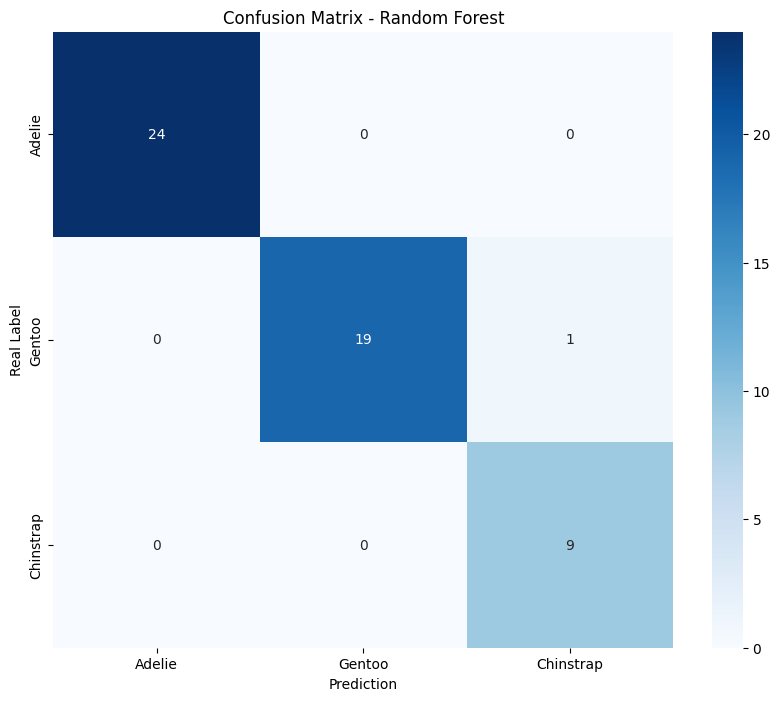

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = model.stages[0].labels 
conf_matrix_np = np.array(metrics.confusionMatrix().toArray())

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_np, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Prediction')
plt.ylabel('Real Label')
plt.show()